# High latitude sample analysis

In [1]:
import pickle
import os
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
os.chdir('..')
from star_sample import Isochrones,StarSample
os.chdir('Data')
pkl_file = open('isochrones_high_lat.pkl', 'rb')
Isochrone_hl = pickle.load(pkl_file)




os.chdir('..')

In [2]:
os.chdir('Data')
pkl_file = open('high_lat_values.pkl', 'rb')
High_Latitude_sample = pickle.load(pkl_file)
os.chdir('..')

Absolute magnitude

In [3]:
High_Latitude_sample.mean_absolute_mag_g_band(abs_column_name='G',magnitude_column='phot_g_mean_mag',parallax_column='parallax')

/Users/mattocallaghan/VaeStar/star_sample.py:56: RuntimeWarning: invalid value encountered in log10
  self.data[abs_column_name] = self.data[magnitude_column].values+5*np.log10(self.data[parallax_column].values/1000)+5


### HR diagram with LOG g

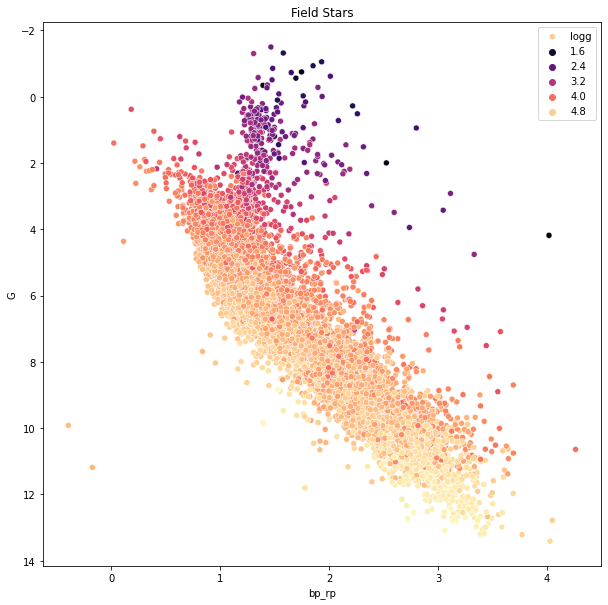

In [4]:
f, axes = plt.subplots(1, 1)
f.set_figheight(10)
f.set_figwidth(10)

scatter=High_Latitude_sample.data
sn.scatterplot(x=scatter['bp_rp'],y=scatter['G'],hue=scatter['logg_gspphot'],ax=axes,label='logg',color='g',palette=sn.color_palette("magma", as_cmap=True))

#axes.set_xlim(0,2.5)
axes.invert_yaxis()
plt.legend()
axes.set_title("Field Stars")
plt.show()

# Cut out the giants by removing low logg values

In [5]:
High_Latitude_sample.data=High_Latitude_sample.data[High_Latitude_sample.data['logg_gspphot']>4.5].reset_index(drop=True)

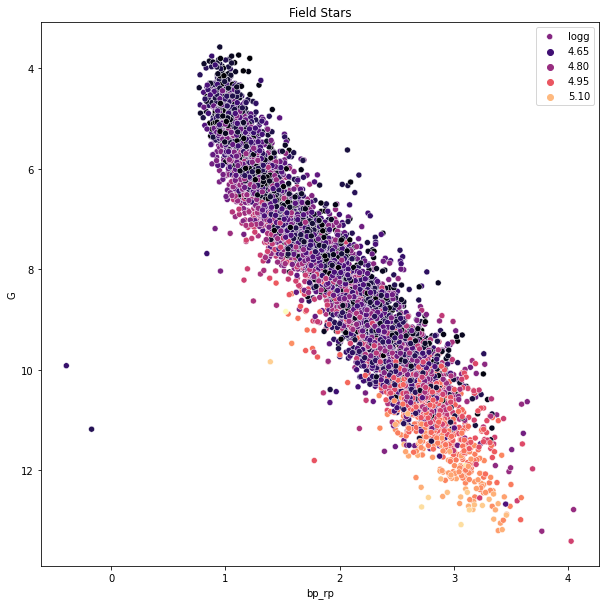

In [6]:
f, axes = plt.subplots(1, 1)
f.set_figheight(10)
f.set_figwidth(10)

scatter=High_Latitude_sample.data
sn.scatterplot(x=scatter['bp_rp'],y=scatter['G'],hue=scatter['logg_gspphot'],ax=axes,label='logg',color='g',palette=sn.color_palette("magma", as_cmap=True))

#axes.set_xlim(0,2.5)
axes.invert_yaxis()
plt.legend()
axes.set_title("Field Stars")
plt.show()

# Make Cuts To Produce a Familiar Family of Isochrones.

Similar to the cluster

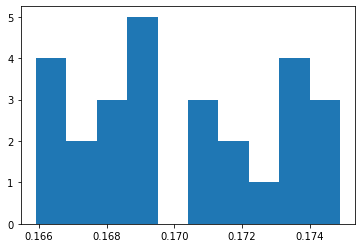

27


In [8]:
High_Latitude_sample.data=High_Latitude_sample.data[High_Latitude_sample.data['mh_gspphot']>0.165].reset_index(drop=True)
High_Latitude_sample.data=High_Latitude_sample.data[High_Latitude_sample.data['mh_gspphot']<0.175].reset_index(drop=True)
plt.hist(High_Latitude_sample.data['mh_gspphot'])
plt.show()
print(len(High_Latitude_sample.data))

# Find distance along the reddening vector.

In [ ]:
stacked_isochrones=Isochrone_hl.stack_isochrones()#_subsample(feh_list,age_list)

In [ ]:
x_values=High_Latitude_sample.to_tensor(expandsize=stacked_isochrones.shape[-2])

In [ ]:
age_list=[8.6]
feh_list=[0.17 for i in range(len(x_values))]#Cluster_sample.data['mh_gspphot']
stacked_isochrones=Isochrone_hl.stack_isochrones_subsample(feh_list,age_list)

In [ ]:
x_columns=High_Latitude_sample.data.columns
isoc_columns=Isochrone_hl.isochrones_list[0].columns
def column_index(name):
    if name in x_columns:
        return np.where(np.array(x_columns)==name)[0][0]
    else:
        return np.where(np.array(isoc_columns)==name)[0][0] +len(x_columns)

In [ ]:
isochrone=torch.cat([x_values,stacked_isochrones],dim=-1)

In [ ]:

truth_1=(isochrone[:,:,column_index('G')]-(isochrone[:,:,column_index('bp_rp')])*isochrone[:,:,column_index('p_slopes')]<=isochrone[:,:,column_index('high_c')]) #box selection
truth_2=(isochrone[:,:,column_index('low_c')]<=isochrone[:,:,column_index('G')]-(isochrone[:,:,column_index('bp_rp')])*isochrone[:,:,column_index('p_slopes')])
truth=torch.logical_and(truth_1,truth_2)


# projection onto the nearest line
x=((1/torch.sqrt(1+isochrone[:,:,column_index('slopes')]**2))*(isochrone[:,:,column_index('G')]-(isochrone[:,:,column_index('bp_rp')])*isochrone[:,:,column_index('slopes')]-isochrone[:,:,column_index('Gaia_G_EDR3')] + isochrone[:,:,column_index('slopes')]*isochrone[:,:,column_index('BPRP')]))

print(torch.abs(x/truth.reshape(x.shape))[23])
idx=torch.argmin(torch.abs(x/truth.reshape(x.shape)).nan_to_num(nan=torch.inf),-1)
x=x.gather(1,idx.view(-1,1))
#error needs to be corrected for absolute magnitude 
x_err=(1/(1+isochrone[:,:,column_index('slopes')]**2))*isochrone[:,:,column_index('phot_g_mean_mag_error')]**2+(isochrone[:,:,column_index('slopes')]*isochrone[:,:,column_index('bp_rp_error')])**2
x_err=x_err.gather(1,idx.view(-1,1))